In [12]:
import glob
import numpy as np
import random
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.transforms import ToTensor

import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Подготовка данных

0


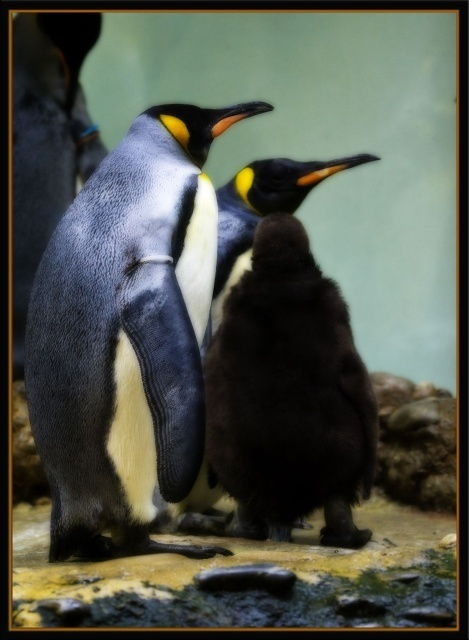

In [2]:
def get_data_list(paths, folders):
    data = []
    for path in paths:
        for i in range(len(folders)):
            for img_path in glob.glob(path + '/' + folders[i] + '/*'):
                data.append({
                    "path": f"{img_path}",
                    "label": i
                })
    return data

train_list = get_data_list(["data/raw/training"], ["non_food", "food"])
val_list = get_data_list(["data/raw/validation"], ["non_food", "food"])
eval_list = get_data_list(["data/raw/evaluation"], ["non_food", "food"])

record = train_list[0]
img = Image.open(record["path"])
print(record["label"])
img

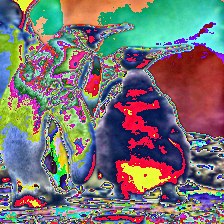

torch.Size([3, 224, 224])
94


In [3]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class FoodOrNotDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        record = self.data[index]
        label = torch.tensor(np.float32(record["label"]))
        img = Image.open(record["path"])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

train_dataset = FoodOrNotDataset(train_list, preprocess)
val_dataset = FoodOrNotDataset(val_list, preprocess)
eval_dataset = FoodOrNotDataset(eval_list, preprocess)
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset)}

display(transforms.ToPILImage()(train_dataset.__getitem__(0)[0]).convert("RGB"))
print(train_dataset.__getitem__(0)[0].shape)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE)
eval_loader = DataLoader(eval_dataset, 1)
print(len(train_loader))

## Функционал обучения

In [8]:
def test_epoch(network, loader):
    network.eval()
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, labels  = data
        inputs, labels = inputs.to(device), labels.to(device)
        output = network(inputs)
        labels = labels.unsqueeze(1)

        output = output.squeeze().data.cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        output[output > 0.5] = 1
        output[output <= 0.5] = 0

        correct += (output == labels).sum()
        try:
            total += labels.shape[0]
        except IndexError:
            total += 1

    accuracy = 100 * correct / total
    # print("Test {} || ACC: {:.4f}".format(str(i+1).zfill(4), accuracy))
    return accuracy

def train_epoch(network, loader, optimizer, criterion):
    network.train()
    batch_loss = 0
    i = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = network(inputs)

        labels = labels.unsqueeze(1)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        batch_loss += loss
        i += 1
        # if i % 20 == 0:
            # print("Train Batch {} || Loss: {:.4f}".format(str(i).zfill(4), batch_loss/i))
    return batch_loss / i

def fit_network(network, criterion, optimizer, train_loader, val_loader, epochs_num):
  best_acc = 0.0
  epochs = range(1, epochs_num+1)
  for epoch in epochs:
    epoch_loss = train_epoch(network, train_loader, optimizer, criterion)
    epoch_acc = test_epoch(network, val_loader)

    info_line = "Epoch {} || Loss: {:.4f} | Test Acc: {:.4f}".format(str(epoch).zfill(3), epoch_loss, epoch_acc)
    print(info_line)

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      # torch.save(network.state_dict(), "Best_ACC.pth.gz")
  print(best_acc)

## Нейросеть 1

In [6]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.DEFAULT')
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Sequential(nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid())
resnet18 = resnet18.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

fit_network(resnet18, criterion, optimizer, train_loader, val_loader, epochs_num=10)

Using cache found in C:\Users\skril/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 001 || Loss: 0.1343 | Test Acc: 97.9000
Epoch 002 || Loss: 0.0754 | Test Acc: 97.1000
Epoch 003 || Loss: 0.0562 | Test Acc: 97.9000
Epoch 004 || Loss: 0.0680 | Test Acc: 97.7000
Epoch 005 || Loss: 0.0818 | Test Acc: 98.0000
Epoch 006 || Loss: 0.0436 | Test Acc: 97.8000
Epoch 007 || Loss: 0.0468 | Test Acc: 97.9000
Epoch 008 || Loss: 0.0330 | Test Acc: 98.0000
Epoch 009 || Loss: 0.0434 | Test Acc: 97.5000
Epoch 010 || Loss: 0.0443 | Test Acc: 97.6000
98.0


In [9]:
print(test_epoch(resnet18, eval_loader))

98.3


## Нейросеть 2

In [11]:
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid())
resnet50 = resnet50.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

fit_network(resnet50, criterion, optimizer, train_loader, val_loader, epochs_num=10)

Using cache found in C:\Users\skril/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 001 || Loss: 0.1202 | Test Acc: 98.0000
Epoch 002 || Loss: 0.0330 | Test Acc: 98.0000
Epoch 003 || Loss: 0.0309 | Test Acc: 98.6000
Epoch 004 || Loss: 0.0151 | Test Acc: 98.8000
Epoch 005 || Loss: 0.0040 | Test Acc: 98.5000
Epoch 006 || Loss: 0.0069 | Test Acc: 98.4000
Epoch 007 || Loss: 0.0083 | Test Acc: 98.7000
Epoch 008 || Loss: 0.0107 | Test Acc: 98.7000
Epoch 009 || Loss: 0.0052 | Test Acc: 98.5000
Epoch 010 || Loss: 0.0153 | Test Acc: 98.1000
98.8


In [14]:
print(test_epoch(resnet50, eval_loader))

98.5


## Нейросеть 3

In [16]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=24, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=24*14*14, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.reshape(-1, 24*14*14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return torch.sigmoid(x)

custom_net = CustomNet()
custom_net = custom_net.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(custom_net.parameters(), lr=0.001)

fit_network(custom_net, criterion, optimizer, train_loader, val_loader, epochs_num=10)

Epoch 001 || Loss: 0.5499 | Test Acc: 80.5000
Epoch 002 || Loss: 0.4153 | Test Acc: 83.0000
Epoch 003 || Loss: 0.3644 | Test Acc: 83.2000
Epoch 004 || Loss: 0.3049 | Test Acc: 83.9000
Epoch 005 || Loss: 0.2603 | Test Acc: 87.5000
Epoch 006 || Loss: 0.2563 | Test Acc: 85.9000
Epoch 007 || Loss: 0.1966 | Test Acc: 87.2000
Epoch 008 || Loss: 0.1723 | Test Acc: 87.2000
Epoch 009 || Loss: 0.1483 | Test Acc: 87.1000
Epoch 010 || Loss: 0.1028 | Test Acc: 87.4000
87.5


In [17]:
print(test_epoch(custom_net, eval_loader))

85.4
